In [20]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta


In [29]:
data_inicial = "02-26-2015"
data_final = "02-26-2025"
# formato da data na api mm-dd-aaaa

url = f"https://olinda.bcb.gov.br/olinda/servico/PTAX/versao/v1/odata/CotacaoDolarPeriodo(dataInicial=@dataInicial,dataFinalCotacao=@dataFinalCotacao)?@dataInicial='{data_inicial}'&@dataFinalCotacao='{data_final}'&$top=10000&$format=json&$select=cotacaoVenda,dataHoraCotacao"


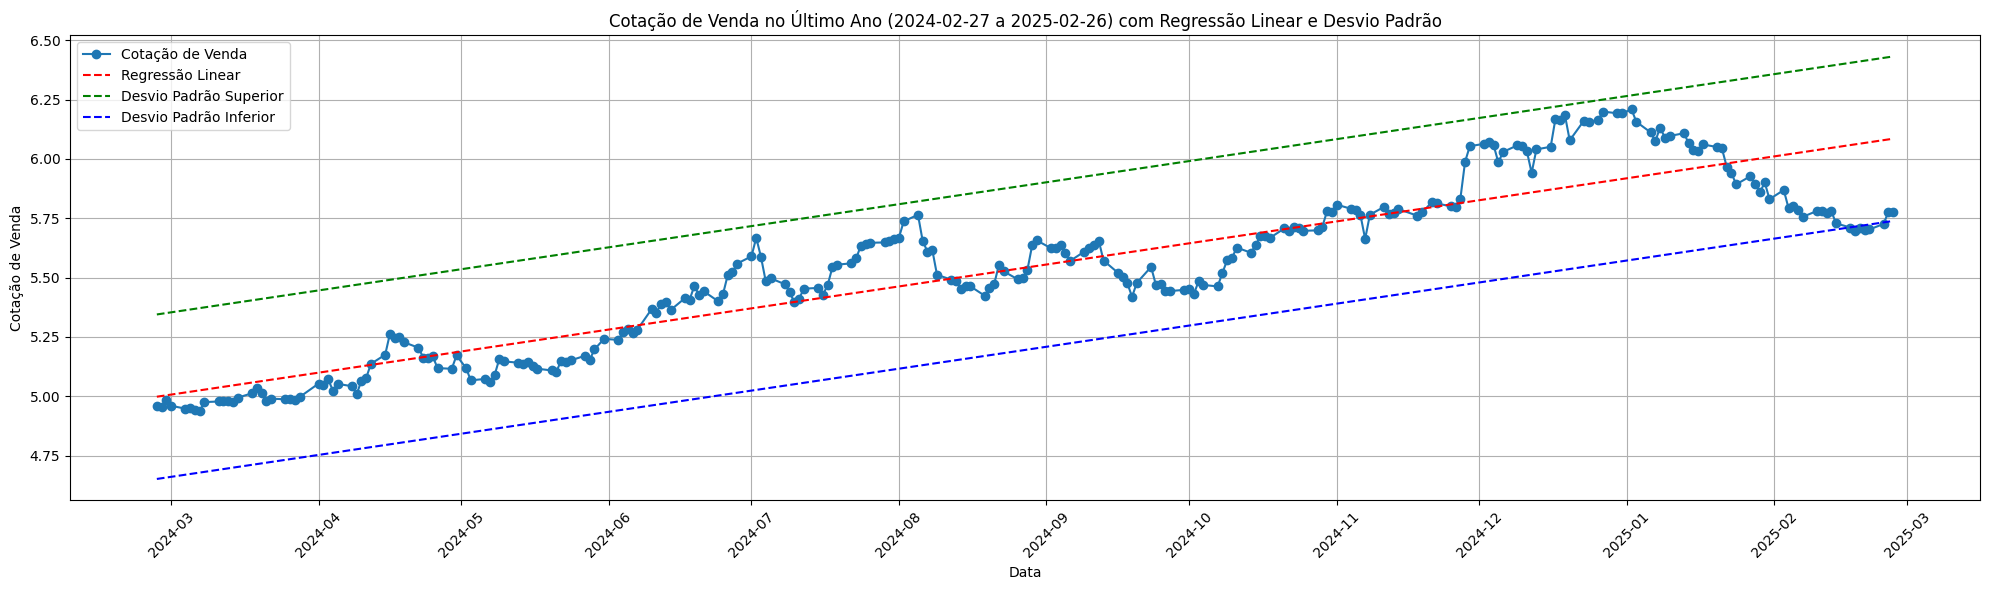

In [30]:
# Requisição da API
response = requests.get(url)
dados = response.json()

# Converte os dados para um DataFrame
df = pd.DataFrame(dados["value"])

# Verifica se há dados
if df.empty:
    raise ValueError("Nenhum dado foi retornado pela API.")

# Extraindo apenas a parte da data e convertendo para datetime
df['data'] = pd.to_datetime(df['dataHoraCotacao'].str.split().str[0])

# Converte as datas para valores numéricos (necessário para np.polyfit)
df['data_num'] = mdates.date2num(df['data'])

# Converter data_final para datetime
data_final_dt = pd.to_datetime(data_final)

# Calcular a data de um ano atrás em relação à data_final
um_ano_atras = data_final_dt - timedelta(days=365)

# Filtrar o DataFrame para incluir apenas os dados do último ano em relação à data_final
df_filtrado = df[(df['data'] >= um_ano_atras) & (df['data'] <= data_final_dt)]

# Verifica se há dados após a filtragem
if df_filtrado.empty:
    raise ValueError("Nenhum dado encontrado no último ano em relação à data_final.")

# Realizar a regressão linear nos dados filtrados
coef = np.polyfit(df_filtrado['data_num'], df_filtrado['cotacaoVenda'], 1)
poly1d_fn = np.poly1d(coef)

# Calcula o desvio padrão da cotação de venda (apenas nos dados filtrados)
std_dev = df_filtrado['cotacaoVenda'].std()

# Criando o gráfico
plt.figure(figsize=(20, 6))

# Plotando os pontos reais
plt.plot(df_filtrado['data'], df_filtrado['cotacaoVenda'], label="Cotação de Venda", marker='o', linestyle='-')

# Adicionando a linha de regressão
plt.plot(df_filtrado['data'], poly1d_fn(df_filtrado['data_num']), color='red', linestyle='--', label="Regressão Linear")

# Adicionando as linhas de desvio padrão
plt.plot(df_filtrado['data'], poly1d_fn(df_filtrado['data_num']) + std_dev, color='green', linestyle='--', label="Desvio Padrão Superior")
plt.plot(df_filtrado['data'], poly1d_fn(df_filtrado['data_num']) - std_dev, color='blue', linestyle='--', label="Desvio Padrão Inferior")

# Formatando o eixo X para exibir os meses
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Mostrar por mês
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Formato da data

# Adicionando título e rótulos
plt.title(f'Cotação de Venda no Último Ano ({um_ano_atras.strftime("%Y-%m-%d")} a {data_final_dt.strftime("%Y-%m-%d")}) com Regressão Linear e Desvio Padrão')
plt.xlabel('Data')
plt.ylabel('Cotação de Venda')
plt.legend()

# Exibindo o gráfico
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
# Criando logica para contar quantas vezes a linha toca os desvios padrao 
print(df_filtrado.head())

255


           Data  Valor Atual  Tocou Superior  Tocou Inferior  Desvio Padrão
0    2016-02-26       3.9578           False           False       0.394208
1    2016-02-29       3.9796           False           False       0.391449
2    2016-03-01       3.9913           False           False       0.391654
3    2016-03-02       3.9116           False           False       0.390328
4    2016-03-03       3.8504           False           False       0.388886
...         ...          ...             ...             ...            ...
2256 2025-02-20       5.7019           False            True       0.353503
2257 2025-02-21       5.7027           False            True       0.351664
2258 2025-02-24       5.7258           False            True       0.348851
2259 2025-02-25       5.7779           False           False       0.348365
2260 2025-02-26       5.7757           False           False       0.346937

[2261 rows x 5 columns]
tocou superior: 464
tocou inferior: 353
total: 817


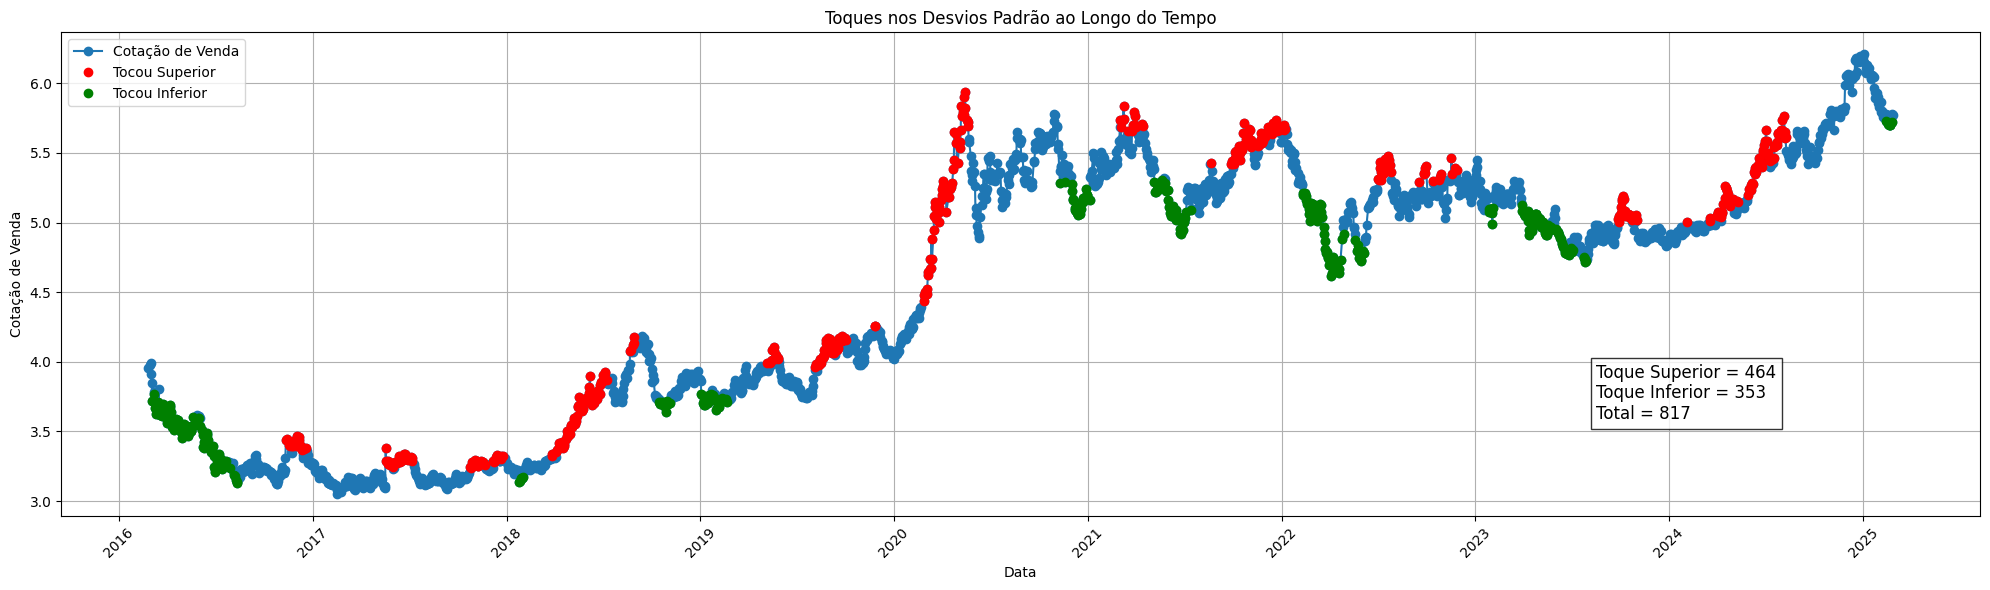

In [46]:
# Extraindo apenas a parte da data e convertendo para datetime
df['data'] = pd.to_datetime(df['dataHoraCotacao'].str.split().str[0])

# Ordenar o DataFrame por data (para garantir que os dados estejam em ordem cronológica)
df = df.sort_values(by='data')

# Converter as datas para valores numéricos (necessário para np.polyfit)
df['data_num'] = mdates.date2num(df['data'])

# Função para contar toques nos desvios padrão
def contar_tocues(df, dia_atual):
    # Definir o período de um ano antes do dia atual
    inicio_periodo = dia_atual - timedelta(days=365)
    fim_periodo = dia_atual - timedelta(days=1)

    # Filtrar os dados para o período de um ano antes do dia atual
    df_periodo_anterior = df[(df['data'] >= inicio_periodo) & (df['data'] <= fim_periodo)]

    # Verificar se há dados suficientes no período anterior
    if df_periodo_anterior.empty:
        return None, None, None, None, None

    # Calcular a regressão linear e o desvio padrão no período anterior
    coef = np.polyfit(df_periodo_anterior['data_num'], df_periodo_anterior['cotacaoVenda'], 1)
    poly1d_fn = np.poly1d(coef)
    std_dev = df_periodo_anterior['cotacaoVenda'].std()

    # Calcular os limites do desvio padrão para o dia atual
    valor_previsto = poly1d_fn(mdates.date2num(dia_atual))
    limite_superior = valor_previsto + std_dev
    limite_inferior = valor_previsto - std_dev

    # Verificar se o valor de venda do dia atual toca ou ultrapassa os limites
    valor_atual = df[df['data'] == dia_atual]['cotacaoVenda'].values[0]
    tocou_superior = valor_atual > limite_superior
    tocou_inferior = valor_atual < limite_inferior

    return tocou_superior, tocou_inferior, poly1d_fn, std_dev, valor_atual

# Lista para armazenar os resultados de cada dia
resultados = []

# Iterar sobre cada dia do DataFrame
for dia_atual in df['data']:
    # Ignorar os primeiros 365 dias (não há dados suficientes para calcular o período anterior)
    if dia_atual < df['data'].min() + timedelta(days=365):
        continue

    # Contar os toques nos desvios padrão
    tocou_superior, tocou_inferior, poly1d_fn, std_dev, valor_atual = contar_tocues(df, dia_atual)

    # Armazenar os resultados
    resultados.append({
        'Data': dia_atual,
        'Valor Atual': valor_atual,
        'Tocou Superior': tocou_superior,
        'Tocou Inferior': tocou_inferior,
        'Desvio Padrão': std_dev
    })

# Converter os resultados para um DataFrame
resultados_df = pd.DataFrame(resultados)

# Exibir os resultados
print(resultados_df)
toque_sup = resultados_df["Tocou Superior"].value_counts()[True]
toque_inf = resultados_df["Tocou Inferior"].value_counts()[True]
total_tocou = toque_sup+toque_inf
print("tocou superior: "+ str(toque_sup))
print("tocou inferior: "+ str(toque_inf))
print("total: "+ str(total_tocou))

# Plotar o gráfico dos toques nos desvios padrão
plt.figure(figsize=(20, 6))
plt.plot(resultados_df['Data'], resultados_df['Valor Atual'], label="Cotação de Venda", marker='o', linestyle='-')
plt.plot(resultados_df['Data'], resultados_df['Valor Atual'].where(resultados_df['Tocou Superior']), 'ro', label="Tocou Superior")
plt.plot(resultados_df['Data'], resultados_df['Valor Atual'].where(resultados_df['Tocou Inferior']), 'go', label="Tocou Inferior")
plt.title('Toques nos Desvios Padrão ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Cotação de Venda')
plt.text(0.8, 0.2,  # Posição do texto (x, y) em relação aos eixos do gráfico
         f"Toque Superior = {toque_sup}\nToque Inferior = {toque_inf}\nTotal = {total_tocou}",  # Texto a ser exibido
         transform=plt.gca().transAxes,  # Usar coordenadas relativas ao gráfico
         fontsize=12,  # Tamanho da fonte
         bbox=dict(facecolor='white', alpha=0.8))  # Caixa de fundo para melhorar a legibilidade
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()